### Assignment 1 Deep Learning and Sensor fusion 2026

Multi class Classification

### Necessary iomport here 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import os 
import numpy as np 
from sklearn.metrics import confusion_matrix

print(f"[INFO] Torch infos: {torch.__version__}")

DATASET_PATH = os.path.join("..", "Dataset", "BoneBreakClassification")

[INFO] Torch infos: 2.7.1+cu118


In [2]:
# some helpers
def load_data(dataset_path, class_names, type_of_data_to_load):
    # for each class name 
    images, labels = list(), list() 
    for el in class_names.keys():
        print(f"[WALKING] Walking into {el}")
        for images_name in os.listdir(os.path.join(dataset_path, el, type_of_data_to_load)):
            full_image_path = os.path.join(dataset_path, el, type_of_data_to_load, images_name)
            images.append(full_image_path)
            labels.append(class_names[el])
            
    return images, labels

# set Dataset path
The path yopu see in the code point to my folder 

```
.
├── Assignment_1
│   ├── Assignment_1_four_layers.ipynb
│   ├── Assignment_1_template.ipynb
│   ├── Assignment_1_three_layers.ipynb
│   └── cnn_ass_1.pt
├── Dataset
│   ├── BoneBreakClassification

```

If you put the data in a different place change it. 

In [3]:
DATASET_PATH = os.path.join("..", "Dataset", "BoneBreakClassification")

### (1) Load dataset

In [4]:
class_names = dict()   

temp = os.listdir(DATASET_PATH)
temp = sorted(temp)
# prep up list and class number together
for i in range(len(temp)):
    class_names[temp[i]] = i

train_data_handler, train_labels_handler = load_data(dataset_path=DATASET_PATH,
                                                       class_names=class_names,
                                                       type_of_data_to_load="Train")

# load test data 
test_data_to_split, test_labels_to_split = load_data(dataset_path=DATASET_PATH,
                                                   class_names=class_names,
                                                   type_of_data_to_load="Test")


[WALKING] Walking into Avulsion fracture
[WALKING] Walking into Comminuted fracture
[WALKING] Walking into Fracture Dislocation
[WALKING] Walking into Greenstick fracture
[WALKING] Walking into Hairline Fracture
[WALKING] Walking into Impacted fracture
[WALKING] Walking into Longitudinal fracture
[WALKING] Walking into Oblique fracture
[WALKING] Walking into Pathological fracture
[WALKING] Walking into Spiral Fracture
[WALKING] Walking into Avulsion fracture
[WALKING] Walking into Comminuted fracture
[WALKING] Walking into Fracture Dislocation
[WALKING] Walking into Greenstick fracture
[WALKING] Walking into Hairline Fracture
[WALKING] Walking into Impacted fracture
[WALKING] Walking into Longitudinal fracture
[WALKING] Walking into Oblique fracture
[WALKING] Walking into Pathological fracture
[WALKING] Walking into Spiral Fracture


# (2) leave this cell because we need to create a val dataset and it is not there as default

In [5]:
# let s create validation we do not have 
val_ratio = 0.2
val_size = int(len(test_data_to_split) * val_ratio)
test_size = len(test_data_to_split) - val_size

test_data_handler = test_data_to_split[:test_size] 
test_labels_handler = test_labels_to_split[:test_size]

validation_data_handler = test_data_to_split[test_size:]
validation_labels_handler = test_labels_to_split[test_size:]

print(f"[TRAIN DATA LOADED] Data loaded complete {len(train_data_handler)} Labeles are {len(train_labels_handler)}")
print(f"[VALIDATION DATA LOADED] Data loaded complete {len(validation_data_handler)} Labeles are {len(validation_labels_handler)}")
print(f"[TEST DATA LOADED] Data loaded complete {len(test_data_handler)} Labeles are {len(test_labels_handler)}")

[TRAIN DATA LOADED] Data loaded complete 904 Labeles are 904
[VALIDATION DATA LOADED] Data loaded complete 26 Labeles are 26
[TEST DATA LOADED] Data loaded complete 105 Labeles are 105


### (3) Here ate two transforms one for training and one for evaluation 

train transform need data augmentation:
- add random flip
- add random rotation
- add color jitter 

both need need:
- resize
- toTensor handler
- Normalize (use the provided MEAN and STD)

Note that the evaluation transform does not need data augmentation.

In [6]:
TARGET_H = 224
TARGET_W = 224
IMAGE_MEAN = [0.485,0.456,0.406]
IMAGE_STD = [0.229,0.224,0.225]

# create transform 
train_transform = transforms.Compose([
    transforms.Resize((TARGET_H, TARGET_W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
])

evaluation_transform = transforms.Compose([
    transforms.Resize((TARGET_H, TARGET_W)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
])

In [7]:
class MyDataset(Dataset):
    def __init__(self, list_of_pathes, list_of_classes, transform=None) -> None:
        super().__init__()
        self.list_of_pathes = list_of_pathes
        self.list_of_classes = list_of_classes
        self.transform = transform

    def __len__(self):
        return len(self.list_of_pathes)
    
    def __getitem__(self, index):
        # select the image at index 
        path = self.list_of_pathes[index]
        # select the label at index 
        label = self.list_of_classes[index]
        # open the image Advice use Image package
        image = Image.open(path).convert("RGB")
        # apply transform 
        if self.transform:
            image = self.transform(image)
        # return image and label
        return image, label 


### (4) Create data loder from the MyDataset class 

In [8]:
train_dataset = MyDataset(list_of_pathes=train_data_handler,
                          list_of_classes=train_labels_handler,
                          transform=train_transform)

validation_dataset = MyDataset(list_of_pathes=validation_data_handler,
                                list_of_classes=validation_labels_handler,
                                transform=evaluation_transform)

test_dataset = MyDataset(list_of_pathes=test_data_handler,
                          list_of_classes=test_labels_handler,
                          transform=evaluation_transform)

# put those here
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

img, label = validation_dataset[0]

print(f"Type of image: {type(img)}")

Type of image: <class 'torch.Tensor'>


### Instance of the CNN 
Use the Sequential API it is faster 
- This cnn has two hidden layers (conv2d -> proper activation -> max pool 2d)  one has 16 untis and the second has 32 units
- Add a flatten layer 
- Classifier need 128 Linear unit proper activation and set dropdown at 0.5
- The last layer of the classifier how many units need?


In [9]:
class LayeredCNN(nn.Module):
    def __init__(self,
                layers_list: list[int],
                dense_units: list[int],
                numbers_of_output_classes: int = 10,
                kernel_size: int = 3,
                padding_size: int = 1,
                pooling_size: int = 2,
                input_channels: int = 3,
                dropout_probabilities: float = 0.5):
        super().__init__()

        layers = []
        input_units = input_channels

        for output_units in layers_list:

            layers += [
                nn.Conv2d(input_units, output_units, kernel_size=kernel_size, padding=padding_size),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=pooling_size)
            ]

            input_units = output_units
        
        self.features = nn.Sequential(*layers)

        multi_layer_perceptron = []
        
        in_features = dense_units[0]

        for h in dense_units[1:]:
            multi_layer_perceptron += [
                nn.Linear(in_features, h),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_probabilities),
            ]

            in_features = h
        
        self.classifier = nn.Sequential(*multi_layer_perceptron)
        self.flatten_layer = nn.Flatten()
        self.final_classifier = nn.Linear(in_features, numbers_of_output_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten_layer(x)
        x = self.classifier(x)
        x = self.final_classifier(x)

        return x


### (5) Add proper optimizer and loss function set training epochs to 50

In [10]:
model = LayeredCNN([16,32], [100352, 128])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

print(f"Model is running on: {device}")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

epochs = 50

Model is running on: cuda


# (6) add here the train and evaluation loop collect loss and accuracy, we want to see curves here 

In [11]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()  
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Track stats
        running_loss += loss.item() * images.size(0)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
    return running_loss / total, correct / total

In [12]:
@torch.no_grad()

def evaluate(model, loader, criterion, device):
    model.eval()  # Turn off Dropout / BatchNorm
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
            
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
            
    return running_loss / total, correct / total

In [13]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

epochs = 50
best_validation_accuracy = 0.0

for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train_one_epoch(model = model, loader=train_loader, criterion=criterion, optimizer=optimizer, device=device)
    val_loss, val_accuracy = evaluate(model=model, loader=validation_loader, criterion=criterion, device=device)

    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    training_accuracy.append(train_accuracy)
    validation_accuracy.append(val_accuracy)

    print(f"[TRAINING EPOCH {epoch} / {epochs}] TRAIN LOSS {train_loss: .4f}, TRAIN ACCURACY {train_accuracy: .3f} | [VALIDATION EPOCH {epoch} / {epochs}] VALIDATION LOSS {val_loss: .4f}, VALIDATION ACCURACY {val_accuracy: .3f}")


    if val_accuracy > best_validation_accuracy:
        best_validation_accuracy = val_accuracy
        torch.save(model.state_dict(), "cnn_bone_break_classification.pt")

print("TRAINING COMPLETE!!!")     
print("BEST VALIDATION ACCURACY: ", best_validation_accuracy)


[TRAINING EPOCH 1 / 50] TRAIN LOSS  4.0601, TRAIN ACCURACY  0.129 | [VALIDATION EPOCH 1 / 50] VALIDATION LOSS  2.3739, VALIDATION ACCURACY  0.000
[TRAINING EPOCH 2 / 50] TRAIN LOSS  2.2968, TRAIN ACCURACY  0.126 | [VALIDATION EPOCH 2 / 50] VALIDATION LOSS  2.3869, VALIDATION ACCURACY  0.000
[TRAINING EPOCH 3 / 50] TRAIN LOSS  2.2895, TRAIN ACCURACY  0.127 | [VALIDATION EPOCH 3 / 50] VALIDATION LOSS  2.4459, VALIDATION ACCURACY  0.000
[TRAINING EPOCH 4 / 50] TRAIN LOSS  2.2930, TRAIN ACCURACY  0.127 | [VALIDATION EPOCH 4 / 50] VALIDATION LOSS  2.4214, VALIDATION ACCURACY  0.000
[TRAINING EPOCH 5 / 50] TRAIN LOSS  2.2801, TRAIN ACCURACY  0.134 | [VALIDATION EPOCH 5 / 50] VALIDATION LOSS  2.4441, VALIDATION ACCURACY  0.000
[TRAINING EPOCH 6 / 50] TRAIN LOSS  2.2690, TRAIN ACCURACY  0.144 | [VALIDATION EPOCH 6 / 50] VALIDATION LOSS  2.3999, VALIDATION ACCURACY  0.038
[TRAINING EPOCH 7 / 50] TRAIN LOSS  2.2623, TRAIN ACCURACY  0.162 | [VALIDATION EPOCH 7 / 50] VALIDATION LOSS  2.3988, VALID

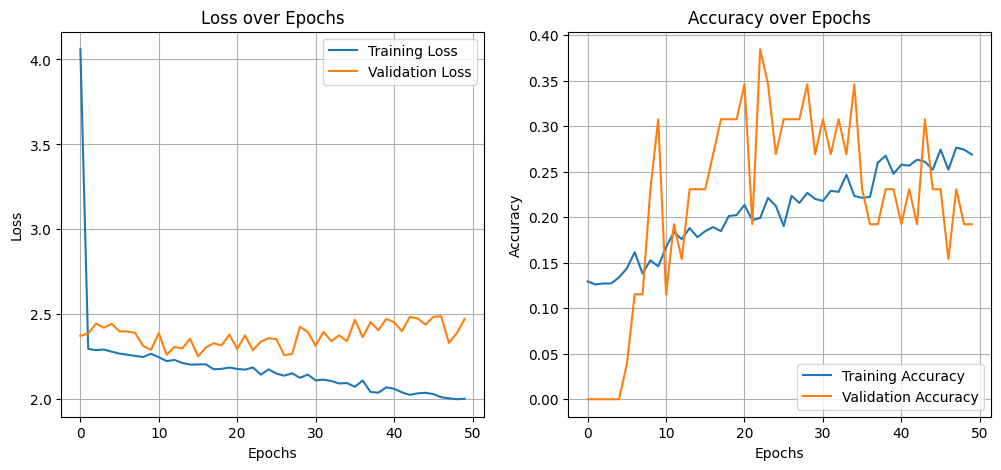

In [14]:

plt.figure(figsize=(12, 5))

# Plot 1: Loss Curve
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# (7) Make prediction and shows some predicted images

Got a batch of 26 images.
Image shape: torch.Size([26, 3, 224, 224])


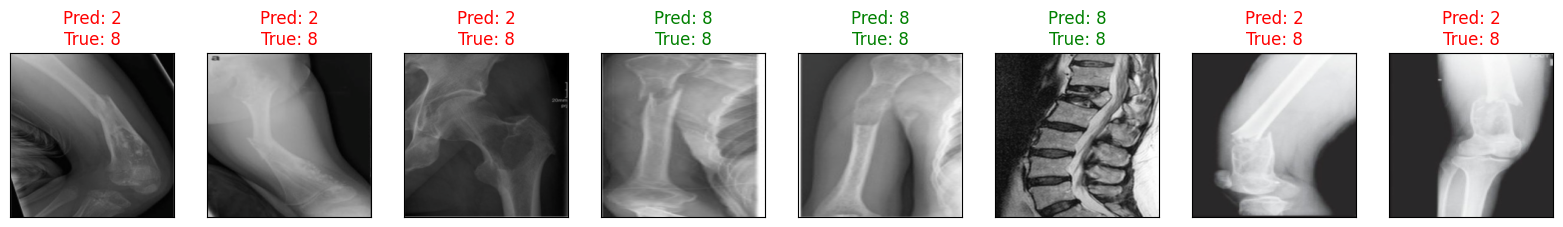

In [32]:
def display_image(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)


model.eval()

iterator = iter(validation_loader)

images, labels = next(iterator)

images, labels = images.to(device), labels.to(device)

print(f"Got a batch of {images.size(0)} images.")
print(f"Image shape: {images.shape}")

with torch.no_grad(): 
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
fig = plt.figure(figsize=(25, 4)) 

for idx in range(8):
    
    ax = fig.add_subplot(1, 10, idx+1, xticks=[], yticks=[])
    
    display_image(images[idx])
    
    
    pred_label = preds[idx].item()
    truth_label = labels[idx].item()
    
    color = "green" if pred_label == truth_label else "red"
    
    ax.set_title(f"Pred: {pred_label}\nTrue: {truth_label}", color=color,)

plt.show()


# (8) Make Evaluation with confusion matrix 

### Instance of a new CNN 
Use the Sequential API it is faster 
- This cnn has tre hidden layers (conv2d -> proper activation -> max pool 2d)  one has 16 untis, the second has 32 units, and the third has 64
- Add a flatten layer 
- Classifier need 128 Linear unit proper activation and set dropdown at 0.5
- The last layer of the classifier how many units need?

Repeat from 5 to 8